In [0]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data
from torchtext import datasets

import urllib.request

from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

from ast import literal_eval
import spacy

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip "/content/drive/My Drive/Colab Notebooks/poster.zip"

Archive:  /content/drive/My Drive/Colab Notebooks/poster.zip
   creating: poster/
  inflating: poster/0.jpg            
  inflating: poster/1.jpg            
  inflating: poster/10.jpg           
  inflating: poster/100.jpg          
  inflating: poster/1000.jpg         
  inflating: poster/10000.jpg        
  inflating: poster/10001.jpg        
  inflating: poster/10002.jpg        
  inflating: poster/10003.jpg        
  inflating: poster/10004.jpg        
  inflating: poster/10005.jpg        
  inflating: poster/10006.jpg        
  inflating: poster/10007.jpg        
  inflating: poster/10008.jpg        
  inflating: poster/10009.jpg        
  inflating: poster/1001.jpg         
  inflating: poster/10010.jpg        
  inflating: poster/10011.jpg        
  inflating: poster/10012.jpg        
  inflating: poster/10013.jpg        
  inflating: poster/10014.jpg        
  inflating: poster/10015.jpg        
  inflating: poster/10016.jpg        
  inflating: poster/10017.jpg        
  infl

In [0]:
def get_words(message, tokenizer = None):
    if tokenizer:
        doc = tokenizer(message)
        return [i.text for i in doc]
    else:
        return message.lower().split('|')

def create_dictionary(messages, min_count = 5, tokenizer = None):
    words_count = {}
    for s in messages:
        words = get_words(s, tokenizer)
        words_unique = list(dict.fromkeys(words))
        for w in words_unique:
            if w not in words_count:
                words_count[w] = 1
            else:
                words_count[w] += 1

    for word in list(words_count.keys()):
        if words_count[word] < min_count:
            del words_count[word]

    index = 1
    for word in list(words_count.keys()):
        words_count[word] = index
        index = index + 1

    return words_count


def transform_text(messages, word_dictionary, tokenizer = None):
    words_arr = np.zeros((len(messages), len(word_dictionary)))
    for i in range(words_arr.shape[0]):
        message_words = get_words(messages[i], tokenizer)
        message_indices = map(word_dictionary.get, message_words)
        for j in message_indices:
            if j is not None:
                words_arr[i, j-1] += 1
    return words_arr

In [0]:
preprocessed = pd.read_csv("drive/My Drive/preprocessed.csv", encoding = "latin1")
print(preprocessed.shape)

(37210, 46)


# Data Filtering

*   English moive
*   Released after 1980



In [0]:
all_data = preprocessed.copy()

In [0]:
all_data = all_data[all_data.original_language == 'en']
print(all_data.shape)

(26824, 46)


In [0]:
pd.to_datetime(all_data.release_date)
all_data['year'] = pd.DatetimeIndex(all_data['release_date']).year
all_data = all_data.loc[all_data.year > 1980]
print(all_data.shape)

(19511, 47)


In [0]:
score_by_genre = all_data.groupby(['Genre'])['IMDB Score'].agg(['mean', 'count']).sort_values(by = 'mean')
score_by_genre[score_by_genre['count']>10]

,mean,count
Genre,,
Action|Horror,4.088235,17
Action|Sci-Fi,4.158333,72
Horror|Sci-Fi,4.162353,85
Action|Horror|Thriller,4.389655,29
Action|Sport,4.490909,11
...,...,...
Documentary|Biography|Music,7.566667,63
Documentary|History|Music,7.573913,23
Documentary|History|War,7.793103,29


# Feature Extraction (Part II) & Train-Val-Test Split

*   Top 3 actors
*   Top 1 director
*   Tokenize overview
*   80-10-10 split



In [0]:
def get_director(l):
  for d in l:
    if d['job'] == 'Director':
      return d['name']
  return ''

directors = all_data['crew'].apply(literal_eval).apply(get_director)

def get_actors(l):
    if isinstance(l, list):
        actors = [d['name'] for d in l]
        if len(actors) >= 3:
            actors = actors[:3]
            return '|'.join(actors)
        return '|'.join(actors)

top_actors = all_data['cast'].apply(literal_eval).apply(get_actors)

In [0]:
all_data['director'] = directors
all_data['actors'] = top_actors

In [0]:
cols = ['posterID','IMDB Score','overview','Genre','director','actors','runtime',
        'num_faces','hue','hue_sd','saturation','saturation_sd ','brightness','brightness_sd','blue','blue_sd','green','green_sd','red','red_sd ']
new_cols = ['posterID','IMDBscore','overview','genre','director','actors','runtime',
        'num_faces','hue','hue_sd','saturation','saturation_sd','brightness','brightness_sd','blue','blue_sd','green','green_sd','red','red_sd']

In [0]:
all_data = all_data[cols]
all_data = all_data.dropna()
print(all_data.shape)

(19429, 20)


In [0]:
all_data.columns = new_cols 
all_data = all_data.reset_index(drop=True)
print(all_data.shape)

(19429, 20)


In [0]:
train_dataset, test_dataset = train_test_split(all_data, test_size=0.3, random_state = 0)
valid_dataset, test_dataset = train_test_split(test_dataset, test_size=0.5, random_state = 0)

train_data = train_dataset.reset_index(drop=True)
valid_data = valid_dataset.reset_index(drop=True)
test_data = test_dataset.reset_index(drop=True)

print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)

train_data.to_csv('train.csv', index = False)
valid_data.to_csv('valid.csv', index = False)
test_data.to_csv('test.csv', index = False)

print('')
print(np.cov(train_data['IMDBscore']))
print(np.cov(valid_data['IMDBscore']))
print(np.cov(test_data['IMDBscore']))

(13600, 20)
(2914, 20)
(2915, 20)

1.4948912934233929
1.4929201393134843
1.4876570362984156


In [0]:
genre_dictionary = create_dictionary(train_data['genre'].astype(str).values, min_count=5)
print('Size of dictionary: ', len(genre_dictionary))
train_genre_matrix = transform_text(train_data['genre'].astype(str).values, genre_dictionary)
valid_genre_matrix = transform_text(valid_data['genre'].astype(str).values, genre_dictionary)
test_genre_matrix = transform_text(test_data['genre'].astype(str).values, genre_dictionary)
print(genre_dictionary)
print(train_genre_matrix.shape)
print(valid_genre_matrix.shape)
print(test_genre_matrix.shape)

Size of dictionary:  23
{'drama': 1, 'comedy': 2, 'romance': 3, 'biography': 4, 'action': 5, 'thriller': 6, 'fantasy': 7, 'documentary': 8, 'horror': 9, 'crime': 10, 'history': 11, 'family': 12, 'short': 13, 'music': 14, 'sport': 15, 'animation': 16, 'sci-fi': 17, 'adventure': 18, 'mystery': 19, 'musical': 20, 'war': 21, 'western': 22, 'news': 23}
(13600, 23)
(2914, 23)
(2915, 23)


In [0]:
director_dictionary = create_dictionary(train_data['director'].astype(str).values, min_count=5)
print('Size of dictionary: ', len(director_dictionary))
train_director_matrix = transform_text(train_data['director'].astype(str).values, director_dictionary)
valid_director_matrix = transform_text(valid_data['director'].astype(str).values, director_dictionary)
test_director_matrix = transform_text(test_data['director'].astype(str).values, director_dictionary)
print(director_dictionary)
print(train_director_matrix.shape)
print(valid_director_matrix.shape)
print(test_director_matrix.shape)

Size of dictionary:  492
{'ken loach': 1, 'sally potter': 2, 'bernard rose': 3, 'bruce beresford': 4, 'mike newell': 5, 'richard loncraine': 6, 'mark rosman': 7, 'patrice leconte': 8, 'atom egoyan': 9, 'dick lowry': 10, 'jay duplass': 11, 'steve james': 12, 'susan seidelman': 13, 'michael apted': 14, 'robert zemeckis': 15, 'nick broomfield': 16, 'todd phillips': 17, 'george a. romero': 18, 'rob reiner': 19, 'mike leigh': 20, 'robert altman': 21, 'joe johnston': 22, 'julien temple': 23, 'albert pyun': 24, 'carlos saura': 25, 'brian trenchard-smith': 26, 'charles band': 27, 'stewart raffill': 28, 'werner herzog': 29, 'garry marshall': 30, 'tim story': 31, 'uwe boll': 32, 'harold ramis': 33, 'mikael hã\x83â¥fstrã\x83â¶m': 34, 'miguel arteta': 35, 'francis ford coppola': 36, 'michael mann': 37, 'shawn levy': 38, 'james benning': 39, 'ben stiller': 40, 'roger donaldson': 41, 'ridley scott': 42, 'neil jordan': 43, 'sean mcnamara': 44, 'christopher cain': 45, 'joe carnahan': 46, 'mike figgis'

In [0]:
actors_dictionary = create_dictionary(train_data['actors'].astype(str).values, min_count = 5)
print('Size of dictionary: ', len(actors_dictionary))
train_actors_matrix = transform_text(train_data['actors'].astype(str).values, actors_dictionary)
valid_actors_matrix = transform_text(valid_data['actors'].astype(str).values, actors_dictionary)
test_actors_matrix = transform_text(test_data['actors'].astype(str).values, actors_dictionary)
print(actors_dictionary)
print(train_actors_matrix.shape)
print(valid_actors_matrix.shape)
print(test_actors_matrix.shape)

Size of dictionary:  1603
{'mark duplass': 1, 'joshua leonard': 2, 'tilda swinton': 3, 'billy zane': 4, 'glenne headly': 5, 'james cosmo': 6, 'jake johnson': 7, 'morgan freeman': 8, 'john cusack': 9, 'alice krige': 10, 'alan rickman': 11, 'hugh grant': 12, 'sally hawkins': 13, 'kris lemche': 14, 'brooke nevin': 15, 'michael sheen': 16, 'dennis quaid': 17, 'hope davis': 18, 'john lithgow': 19, 'teri garr': 20, 'randy quaid': 21, 'hilary duff': 22, 'jennifer coolidge': 23, 'chad michael murray': 24, 'robert carradine': 25, 'anthony edwards': 26, 'hailee steinfeld': 27, 'cuba gooding jr.': 28, 'tom berenger': 29, 'edward norton': 30, 'naomi watts': 31, 'lea thompson': 32, 'danielle harris': 33, '': 34, 'jackie chan': 35, 'ian holm': 36, 'sarah polley': 37, 'billy crudup': 38, 'anton yelchin': 39, 'delroy lindo': 40, 'blair underwood': 41, 'harry connick jr.': 42, 'mickey rooney': 43, 'gina gershon': 44, 'liev schreiber': 45, 'cary elwes': 46, 'christopher lloyd': 47, 'lacey chabert': 48, 

In [0]:
tokenizer = spacy.load("en_core_web_sm", disable=["tagger", "parser","ner"])
overview_dictionary = create_dictionary(train_data['overview'], min_count = 20, tokenizer = tokenizer)
print('Size of dictionary: ', len(overview_dictionary))
train_overview_matrix = transform_text(train_data['overview'].astype(str).values, overview_dictionary)
valid_overview_matrix = transform_text(valid_data['overview'].astype(str).values, overview_dictionary)
test_overview_matrix = transform_text(test_data['overview'].astype(str).values, overview_dictionary)
print(overview_dictionary)
print(train_overview_matrix.shape)
print(valid_overview_matrix.shape)
print(test_overview_matrix.shape)

Size of dictionary:  3884
{'The': 1, 'child': 2, 'of': 3, 'parents': 4, 'living': 5, 'on': 6, 'a': 7, ',': 8, 'Victor': 9, 'is': 10, 'to': 11, 'the': 12, 'sex': 13, 'and': 14, 'drugs': 15, 'that': 16, 'his': 17, 'world': 18, 'but': 19, 'smart': 20, 'enough': 21, 'know': 22, 'if': 23, 'he': 24, 'going': 25, 'survive': 26, 'has': 27, 'get': 28, 'out': 29, '.': 30, 'your': 31, 'life': 32, 'somewhat': 33, 'complete': 34, 'with': 35, 'house': 36, 'job': 37, 'wife': 38, 'then': 39, 'best': 40, 'friend': 41, 'from': 42, 'college': 43, 'comes': 44, 'at': 45, 'door': 46, '2': 47, 'During': 48, '-': 49, 'party': 50, 'plan': 51, 'between': 52, 'two': 53, 'friends': 54, 'create': 55, 'an': 56, 'Art': 57, 'Film': 58, 'really': 59, 'straight': 60, 'men': 61, 'having': 62, 'Ã¢Â\x80Â\x9d': 63, 'If': 64, 'they': 65, 'only': 66, 'knew': 67, 'how': 68, 'much': 69, 'this': 70, 'would': 71, 'all': 72, 'their': 73, 'lives': 74, 'Just': 75, 'moments': 76, 'before': 77, 'third': 78, 'wedding': 79, 'astonishin

## Prepare Overview for CNN

In [0]:
TEXT = data.Field(tokenize = 'spacy')

fields = [(None, None),(None, None),('overview',TEXT)]
train_text, valid_text, test_text = data.TabularDataset.splits(
                                        path = '',
                                        train = 'train.csv',
                                        validation = 'valid.csv',
                                        test = 'test.csv',
                                        format = 'csv',
                                        fields = fields,
                                        skip_header = True
)

In [0]:
MAX_VOCAB_SIZE = len(overview_dictionary)

TEXT.build_vocab(train_text, 
                 max_size = MAX_VOCAB_SIZE)

print(vars(train_text.examples[0]))

print(vars(TEXT.vocab)['stoi'])

{'overview': ['The', 'neglected', 'child', 'of', 'parents', 'living', 'on', 'a', 'commune', ',', 'Victor', 'is', 'helpless', 'to', 'resist', 'the', 'atmosphere', 'of', 'sex', 'and', 'drugs', 'that', 'permeates', 'his', 'world', ',', 'but', 'he"s', 'smart', 'enough', 'to', 'know', 'that', 'if', 'he', 'is', 'going', 'to', 'survive', ',', 'he', 'has', 'to', 'get', 'out', '.']}
defaultdict(<function _default_unk_index at 0x7f26d6f7d048>, {'<unk>': 0, '<pad>': 1, ',': 2, 'the': 3, '.': 4, 'a': 5, 'and': 6, 'to': 7, 'of': 8, 'in': 9, 'his': 10, 'is': 11, '-': 12, "'s": 13, 'with': 14, 'her': 15, 'for': 16, 'on': 17, 'he': 18, 'that': 19, 'an': 20, 'who': 21, 'by': 22, 'their': 23, 'as': 24, 'The': 25, 'from': 26, '"': 27, 'A': 28, 'they': 29, 'has': 30, 'are': 31, ')': 32, '(': 33, 'life': 34, 'she': 35, 'at': 36, 'him': 37, 'into': 38, 'it': 39, 'when': 40, 'up': 41, 'one': 42, 'out': 43, 'but': 44, 'be': 45, 'young': 46, 'this': 47, 'about': 48, 'film': 49, 'man': 50, 'When': 51, 'all': 52

In [0]:
device = "cuda:0"
train_iterator = data.BucketIterator(
    train_text, 
    batch_size = train_data.shape[0],
    device = device,
    shuffle = False)

for batch in train_iterator:
  train_text_indices = batch.overview.permute(1, 0)
  print(train_text_indices.shape)

valid_iterator = data.BucketIterator(
    valid_text, 
    batch_size = valid_data.shape[0],
    device = device,
    shuffle = False)

for batch in valid_iterator:
  valid_text_indices = batch.overview.permute(1, 0)
  print(valid_text_indices.shape)

  
test_iterator = data.BucketIterator(
    test_text, 
    batch_size = test_data.shape[0],
    device = device,
    shuffle = False)

for batch in test_iterator:
  test_text_indices = batch.overview.permute(1, 0)
  print(test_text_indices.shape)

torch.Size([13600, 218])
torch.Size([2914, 210])
torch.Size([2915, 210])


In [0]:
l = list(map(vars(TEXT.vocab)['stoi'].get, vars(train_text.examples[0])['overview']))

max_l = max(train_text_indices.shape[1], valid_text_indices.shape[1], test_text_indices.shape[1])

train_text_indices = np.ones((train_data.shape[0],max_l), dtype = int)
valid_text_indices = np.ones((valid_data.shape[0],max_l), dtype = int)
test_text_indices = np.ones((test_data.shape[0],max_l), dtype = int)

for i in range(train_data.shape[0]):
  l = list(map(vars(TEXT.vocab)['stoi'].get, vars(train_text.examples[i])['overview']))
  train_text_indices[i,:len(l)] = l

for i in range(valid_data.shape[0]):
  l = list(map(vars(TEXT.vocab)['stoi'].get, vars(valid_text.examples[i])['overview']))
  valid_text_indices[i,:len(l)] = l
  
for i in range(test_data.shape[0]):
  l = list(map(vars(TEXT.vocab)['stoi'].get, vars(test_text.examples[i])['overview']))
  test_text_indices[i,:len(l)] = l
  
print(train_text_indices.shape)
print(valid_text_indices.shape)
print(test_text_indices.shape)

(13600, 218)
(2914, 218)
(2915, 218)


# Encoding & Prepare Data

In [0]:
train_data = pd.read_csv('train.csv')
valid_data = pd.read_csv('valid.csv')
test_data = pd.read_csv('test.csv')
train_data = train_data.drop(columns = ['overview','genre','director','actors'])
valid_data = valid_data.drop(columns = ['overview','genre','director','actors'])
test_data = test_data.drop(columns = ['overview','genre','director','actors'])
train_data = pd.concat([train_data, pd.DataFrame(train_genre_matrix, columns = genre_dictionary.keys()), pd.DataFrame(train_director_matrix, columns = director_dictionary.keys()), 
                        pd.DataFrame(train_actors_matrix, columns = actors_dictionary.keys()), pd.DataFrame(train_overview_matrix,  columns = overview_dictionary.keys())], axis=1)
valid_data = pd.concat([valid_data, pd.DataFrame(valid_genre_matrix, columns = genre_dictionary.keys()), pd.DataFrame(valid_director_matrix, columns = director_dictionary.keys()), 
                       pd.DataFrame(valid_actors_matrix, columns = actors_dictionary.keys() ), pd.DataFrame(valid_overview_matrix, columns = overview_dictionary.keys())], axis=1)
test_data = pd.concat([test_data, pd.DataFrame(test_genre_matrix, columns = genre_dictionary.keys()), pd.DataFrame(test_director_matrix, columns = director_dictionary.keys()), 
                       pd.DataFrame(test_actors_matrix, columns = actors_dictionary.keys() ), pd.DataFrame(test_overview_matrix, columns = overview_dictionary.keys())], axis=1)

In [0]:
train_data.to_csv('train1.csv', index = False)
valid_data.to_csv('valid1.csv', index = False)
test_data.to_csv('test1.csv', index = False)

In [0]:
train_data = pd.read_csv('train1.csv')
valid_data = pd.read_csv('valid1.csv')
test_data = pd.read_csv('test1.csv')

In [0]:
train_data

,posterID,IMDBscore,runtime,num_faces,hue,hue_sd,saturation,saturation_sd,brightness,brightness_sd,blue,blue_sd,green,green_sd,red,red_sd,drama,comedy,romance,biography,action,thriller,fantasy,documentary,horror,crime,history,family,short,music,sport,animation,sci-fi,adventure,mystery,musical,war,western,news,ken loach,...,grisly,sweet,concerns,Old,dictator,scheming,personalities,solo,December,hostile,connected,budding,2003,Friends,locate,Moscow,therapist,records,wall,DNA,emerge,slightly,winds,houses,alcohol,necessary,Oregon,broadcast,fathers,shock,dysfunctional,Many,circus,deaf,identities,Pete,mute,35,Devil,People
0,32402.jpg,4.9,88.0,0.0,89.409035,52.614906,128.736543,88.064210,101.076009,83.400584,85.636928,72.900289,80.667100,84.242349,89.145326,90.019602,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,13923.jpg,6.1,94.0,1.0,71.211420,75.131464,91.744507,42.014546,197.488850,60.942483,143.538576,56.752155,145.099854,59.012197,194.170035,65.356209,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11038.jpg,6.1,98.0,0.0,46.977193,50.078128,88.376165,68.034921,84.006098,65.414760,61.738450,58.899170,71.716728,63.532656,78.617798,65.191101,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,17344.jpg,6.4,109.0,1.0,65.408398,80.574272,116.565593,104.681682,199.891631,67.589193,127.142091,104.334749,127.261665,108.458901,199.685224,67.837758,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,501.jpg,7.2,93.0,1.0,58.487594,57.218151,129.508269,67.404898,171.644215,73.348255,130.101219,60.828449,115.417380,77.937865,140.103072,98.594190,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13595,17585.jpg,6.5,103.0,0.0,37.190256,58.000491,54.139959,81.814125,224.043817,55.899806,198.688311,79.082830,197.913065,80.542409,215.606822,70.591333,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13596,24976.jpg,7.3,80.0,0.0,73.034346,40.500036,115.867478,57.914678,102.475670,68.073339,90.707324,69.961597,84.175857,63.227484,73.533483,62.754939,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13597,18879.jpg,6.9,48.0,0.0,63.749857,39.003729,38.402726,53.875712,106.816059,62.338329,103.573369,62.733821,104.785939,63.630866,99.079306,58.480168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1

In [0]:
for col in ['runtime','num_faces','hue','hue_sd','saturation','saturation_sd','brightness','brightness_sd',
            'blue','blue_sd','green','green_sd','red','red_sd']:
  mean_feature = np.mean(train_data[col])
  sd_feature = np.std(train_data[col])
  if sd_feature != 0:
    train_data[col] = (train_data[col] - mean_feature) / sd_feature
    valid_data[col] = (valid_data[col] - mean_feature) / sd_feature
    test_data[col] = (test_data[col] - mean_feature) / sd_feature
  else:
    train_data[col] = (train_data[col] - mean_feature) 
    valid_data[col] = (valid_data[col] - mean_feature) 
    test_data[col] = (test_data[col] - mean_feature) 

In [0]:
train_data

,posterID,IMDBscore,runtime,num_faces,hue,hue_sd,saturation,saturation_sd,brightness,brightness_sd,blue,blue_sd,green,green_sd,red,red_sd,drama,comedy,romance,biography,action,thriller,fantasy,documentary,horror,crime,history,family,short,music,sport,animation,sci-fi,adventure,mystery,musical,war,western,news,ken loach,...,grisly,sweet,concerns,Old,dictator,scheming,personalities,solo,December,hostile,connected,budding,2003,Friends,locate,Moscow,therapist,records,wall,DNA,emerge,slightly,winds,houses,alcohol,necessary,Oregon,broadcast,fathers,shock,dysfunctional,Many,circus,deaf,identities,Pete,mute,35,Devil,People
0,32402.jpg,4.9,-0.214485,-0.628921,1.154814,0.464228,0.604670,1.092677,-0.601549,0.645886,-0.241329,0.261589,-0.499044,0.827856,-0.579642,0.949121,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,13923.jpg,6.1,-0.052971,0.408349,0.538177,1.880028,-0.193467,-1.276406,1.293056,-0.775433,0.901365,-0.593084,0.811212,-0.722713,1.462050,-0.604356,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11038.jpg,6.1,0.054705,-0.628921,-0.283015,0.304720,-0.266142,0.062245,-0.936989,-0.492394,-0.712967,-0.479449,-0.681052,-0.444899,-0.784298,-0.614756,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,17344.jpg,6.4,0.350815,0.408349,0.341538,2.222262,0.342071,1.947585,1.340273,-0.354779,0.577779,1.925322,0.448468,2.316132,1.569266,-0.448050,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,501.jpg,7.2,-0.079890,0.408349,0.107022,0.753671,0.621321,0.029833,0.785184,0.009698,0.636177,-0.377338,0.207612,0.440401,0.410982,1.489210,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13595,17585.jpg,6.5,0.189300,-0.628921,-0.614651,0.802864,-1.004819,0.771134,1.814887,-1.094572,1.989749,0.588813,1.885183,0.600469,1.878784,-0.274610,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13596,24976.jpg,7.3,-0.429838,-0.628921,0.599948,-0.297533,0.327008,-0.458404,-0.574044,-0.324139,-0.141264,0.106053,-0.427693,-0.463654,-0.883138,-0.768203,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13597,18879.jpg,6.9,-1.291247,-0.628921,0.285337,-0.391618,-1.344365,-0.666193,-0.488751,-0.687094,0.112648,-0.276492,-0.008581,-0.438864,-0.386524,-1.037458,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [0]:
print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)
train_X = train_data.drop(columns=['posterID','IMDBscore'])
valid_X = valid_data.drop(columns=['posterID','IMDBscore'])
test_X = test_data.drop(columns=['posterID','IMDBscore'])

(13600, 6018)
(2914, 6018)
(2915, 6018)


# Linear Regressions

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [0]:
print(np.cov(train_data['IMDBscore']))
print(np.cov(valid_data['IMDBscore']))
print(np.cov(test_data['IMDBscore']))

1.4948912934233929
1.4929201393134843
1.4876570362984156


In [0]:
reg = LinearRegression().fit(train_X, train_data['IMDBscore'])

print('Train R^2: ', reg.score(train_X, train_data['IMDBscore']))
print('Train MSE: ', mean_squared_error(reg.predict(train_X), train_data['IMDBscore']))

print('Valid R^2: ', reg.score(valid_X, valid_data['IMDBscore']))
print('Valid MSE: ', mean_squared_error(reg.predict(valid_X), valid_data['IMDBscore']))

print('Test R^2: ', reg.score(test_X, test_data['IMDBscore']))
print('Test MSE: ', mean_squared_error(reg.predict(test_X), test_data['IMDBscore']))

Train R^2:  0.5314395710262148
Train MSE:  0.7003954022666914
Valid R^2:  0.3647053394102334
Valid MSE:  0.9481187147462554
Test R^2:  0.37453820225489276
Test MSE:  0.9301534427581062


In [0]:
reg = Ridge(alpha = 10, random_state = 0).fit(train_X, train_data['IMDBscore'])

print('Train R^2: ', reg.score(train_X, train_data['IMDBscore']))
print('Train MSE: ', mean_squared_error(reg.predict(train_X), train_data['IMDBscore']))

print('Valid R^2: ', reg.score(valid_X, valid_data['IMDBscore']))
print('Valid MSE: ', mean_squared_error(reg.predict(valid_X), valid_data['IMDBscore']))

print('Test R^2: ', reg.score(test_X, test_data['IMDBscore']))
print('Test MSE: ', mean_squared_error(reg.predict(test_X), test_data['IMDBscore']))

Train R^2:  0.4842238488322514
Train MSE:  0.7709725844068492
Valid R^2:  0.40883999856399234
Valid MSE:  0.8822518046202048
Test R^2:  0.4099347903240921
Test MSE:  0.8775135239442735


In [0]:
reg = Lasso(alpha = 0.0001, random_state = 0).fit(train_X, train_data['IMDBscore'])

print('Train R^2: ', reg.score(train_X, train_data['IMDBscore']))
print('Train MSE: ', mean_squared_error(reg.predict(train_X), train_data['IMDBscore']))

print('Valid R^2: ', reg.score(valid_X, valid_data['IMDBscore']))
print('Valid MSE: ', mean_squared_error(reg.predict(valid_X), valid_data['IMDBscore']))

print('Test R^2: ', reg.score(test_X, test_data['IMDBscore']))
print('Test MSE: ', mean_squared_error(reg.predict(test_X), test_data['IMDBscore']))

Train R^2:  0.5110384828599561
Train MSE:  0.7308905688862447
Valid R^2:  0.4014952078475995
Valid MSE:  0.8932132276670188
Test R^2:  0.40631417511858736
Test MSE:  0.8828979098659138


In [0]:
from sklearn.feature_selection import SelectFromModel

reg = Lasso(alpha = 0.01, random_state = 0).fit(train_X, train_data['IMDBscore'])

print('Train R^2: ', reg.score(train_X, train_data['IMDBscore']))
print('Train MSE: ', mean_squared_error(reg.predict(train_X), train_data['IMDBscore']))

print('Valid R^2: ', reg.score(valid_X, valid_data['IMDBscore']))
print('Valid MSE: ', mean_squared_error(reg.predict(valid_X), valid_data['IMDBscore']))

feature_select = SelectFromModel(reg, prefit=True)
feature_name = test_X.columns[feature_select.get_support()]
print(feature_name.values.tolist())

Train R^2:  0.3390842741126542
Train MSE:  0.9879245174652769
Valid R^2:  0.3368330266852264
Valid MSE:  0.9897155720113658
['runtime', 'num_faces', 'hue_sd', 'saturation', 'saturation_sd', 'brightness', 'brightness_sd', 'blue_sd', 'red', 'drama', 'comedy', 'biography', 'action', 'thriller', 'documentary', 'horror', 'short', 'animation', 'sci-fi']


In [0]:
reg = LinearRegression().fit(train_X.iloc[:,2:14], train_data['IMDBscore'])

print('Train R^2: ', reg.score(train_X.iloc[:,2:14], train_data['IMDBscore']))
print('Train MSE: ', mean_squared_error(reg.predict(train_X.iloc[:,2:14]), train_data['IMDBscore']))

print('Valid R^2: ', reg.score(valid_X.iloc[:,2:14], valid_data['IMDBscore']))
print('Valid MSE: ', mean_squared_error(reg.predict(valid_X.iloc[:,2:14]), valid_data['IMDBscore']))

Train R^2:  0.017213742643326424
Train MSE:  1.4690505930495772
Valid R^2:  0.015056590510741595
Valid MSE:  1.4699372392581271


# Decision Tree & Random Forest Regression

In [0]:
from sklearn.tree import DecisionTreeRegressor

dtreg = DecisionTreeRegressor(random_state = 0, max_depth = 8)
dtreg.fit(train_X, train_data['IMDBscore'])

print('Train R^2: ', dtreg.score(train_X, train_data['IMDBscore']))
print('Train MSE: ', mean_squared_error(dtreg.predict(train_X), train_data['IMDBscore']))

print('Valid R^2: ', dtreg.score(valid_X, valid_data['IMDBscore']))
print('Valid MSE: ', mean_squared_error(dtreg.predict(valid_X), valid_data['IMDBscore']))

print('Test R^2: ', dtreg.score(test_X, test_data['IMDBscore']))
print('Test MSE: ', mean_squared_error(dtreg.predict(test_X), test_data['IMDBscore']))

Train R^2:  0.44598932030993294
Train MSE:  0.8281248455218498
Valid R^2:  0.3696024041459127
Valid MSE:  0.9408102970760813
Test R^2:  0.39754164151658333
Test MSE:  0.8959439541823415


In [0]:
from sklearn.ensemble import RandomForestRegressor

rfreg = RandomForestRegressor(max_depth=32, random_state=0,
                            n_estimators=100)

rfreg.fit(train_X, train_data['IMDBscore'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=32,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [0]:
print('Train R^2: ', rfreg.score(train_X, train_data['IMDBscore']))
print('Train MSE: ', mean_squared_error(rfreg.predict(train_X), train_data['IMDBscore']))

print('Valid R^2: ', rfreg.score(valid_X, valid_data['IMDBscore']))
print('Valid MSE: ', mean_squared_error(rfreg.predict(valid_X), valid_data['IMDBscore']))

print('Test R^2: ', rfreg.score(test_X, test_data['IMDBscore']))
print('Test MSE: ', mean_squared_error(rfreg.predict(test_X), test_data['IMDBscore']))

Train R^2:  0.8819732594105109
Train MSE:  0.17642417357874368
Valid R^2:  0.41546445451245406
Valid MSE:  0.8723654148087148
Test R^2:  0.4253147058330188
Test MSE:  0.8546413334899065


Index(['documentary', 'runtime', 'horror', 'drama', 'saturation_sd', 'hue_sd',
       'hue', 'saturation', 'blue_sd', 'green_sd', 'red_sd', 'brightness_sd',
       'red', 'green', 'blue', 'brightness', 'animation', 'action', 'short',
       'sci-fi'],
      dtype='object')
[0.14224419 0.13275967 0.08357367 0.05096358 0.03726235 0.03671717
 0.0349223  0.03402988 0.03002757 0.02850436 0.02790697 0.02731554
 0.02706554 0.02588318 0.02568622 0.02454099 0.02124341 0.02060925
 0.01014084 0.00833281]


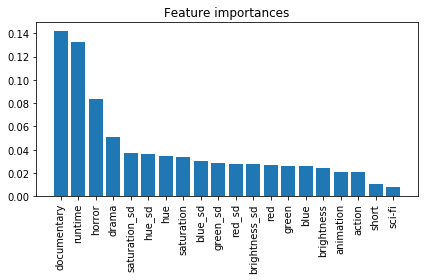

In [0]:
importances_order = np.argsort(rfreg.feature_importances_)[::-1]
print(train_X.columns[importances_order[:20]])
print(rfreg.feature_importances_[importances_order[:20]])
plt.figure()
plt.title("Feature importances")
plt.bar(range(20),rfreg.feature_importances_[importances_order[:20]])
plt.xticks(range(20), train_X.columns[importances_order[:20]], rotation='vertical')
plt.tight_layout()
plt.savefig('drive/My Drive/randomforest.png')
plt.show()


# Permutation Feature Importances

In [0]:
print(train_X.columns[0:1]) # runtime
print(train_X.columns[1:14]) # poster
print(train_X.columns[14:37]) # genre
print(train_X.columns[37:529]) # director
print(train_X.columns[529:2132]) # actor
print(train_X.columns[2132:6016]) # synopses

Index(['runtime'], dtype='object')
Index(['num_faces', 'hue', 'hue_sd', 'saturation', 'saturation_sd',
       'brightness', 'brightness_sd', 'blue', 'blue_sd', 'green', 'green_sd',
       'red', 'red_sd'],
      dtype='object')
Index(['drama', 'comedy', 'romance', 'biography', 'action', 'thriller',
       'fantasy', 'documentary', 'horror', 'crime', 'history', 'family',
       'short', 'music', 'sport', 'animation', 'sci-fi', 'adventure',
       'mystery', 'musical', 'war', 'western', 'news'],
      dtype='object')
Index(['ken loach', 'sally potter', 'bernard rose', 'bruce beresford',
       'mike newell', 'richard loncraine', 'mark rosman', 'patrice leconte',
       'atom egoyan', 'dick lowry',
       ...
       'andy tennant', 'roel reinãâ©', 'henry jaglom', 'gary trousdale',
       'glenn a. jordan', 'john landis', 'dolph lundgren', 'dito montiel',
       'tom shadyac', 'mark rydell'],
      dtype='object', length=492)
Index(['mark duplass', 'joshua leonard', 'tilda swinton', 'bill

In [0]:
np.random.seed(0)
breaks = [0, 1, 14, 37, 529, 2132, 6016]
mse_permute = []
for i in range(len(breaks)-1):
  iters = np.zeros(10)
  for j in range(10):
    train_X_copy = train_X.copy()
    train_X_copy.iloc[:,breaks[i]:breaks[i+1]] = np.random.permutation(train_X_copy.iloc[:,breaks[i]:breaks[i+1]])
    #rfreg_permute = RandomForestRegressor(max_depth=32, random_state=0,
    #                        n_estimators=100)
    #rfreg_permute.fit(train_X_copy, train_data['IMDBscore'])
    iters[j] = mean_squared_error(rfreg.predict(train_X_copy), train_data['IMDBscore'])
  mse_permute.append(np.mean(iters))
  print(i)

print(mse_permute)

0
1
2
3
4
5
[0.8950430264668349, 0.7824430583931985, 1.7198044410740256, 0.20448712403568986, 0.27149737883945674, 0.1764297228347879]


['genre' 'runtime' 'poster' 'actor' 'director' 'synopses']
[1.54338027e+00 7.18618853e-01 6.06018885e-01 9.50732053e-02
 2.80629505e-02 5.54925604e-06]


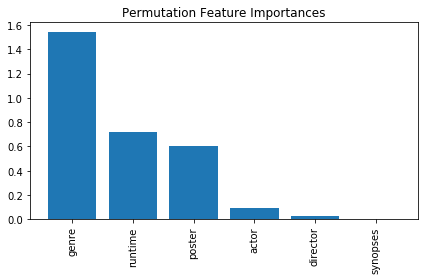

In [0]:
importances_permute = np.array(mse_permute) - mean_squared_error(rfreg.predict(train_X), train_data['IMDBscore'])
importances_order = np.argsort(importances_permute)[::-1]

groups = np.array(['runtime','poster','genre','director','actor','synopses'])
print(groups[importances_order])
print(importances_permute[importances_order])
plt.figure()
plt.title("Permutation Feature Importances")
plt.bar(range(len(groups)), importances_permute[importances_order])
plt.xticks(range(len(groups)), groups[importances_order], rotation='vertical')
plt.tight_layout()
plt.savefig('drive/My Drive/permutation_train.png')
plt.show()

# XGBoost


In [0]:
import xgboost as xgb
xgreg = xgb.XGBRegressor(objective ='reg:squarederror')
xgreg.fit(train_X, train_data['IMDBscore'])

print('Train R^2: ', xgreg.score(train_X, train_data['IMDBscore']))
print('Train MSE: ', mean_squared_error(xgreg.predict(train_X), train_data['IMDBscore']))

print('Valid R^2: ', xgreg.score(valid_X, valid_data['IMDBscore']))
print('Valid MSE: ', mean_squared_error(xgreg.predict(valid_X), valid_data['IMDBscore']))

print('Test R^2: ', xgreg.score(test_X, test_data['IMDBscore']))
print('Test MSE: ', mean_squared_error(xgreg.predict(test_X), test_data['IMDBscore']))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Train R^2:  0.4415212015996126
Train MSE:  0.8348037061510842
Valid R^2:  0.404983889449547
Valid MSE:  0.8880066919887136
Test R^2:  0.4188955146460499
Test MSE:  0.8641876124214214


# Support Vector Regression

In [0]:
from sklearn.svm import SVR
import numpy as np
svr = SVR(gamma='scale', C=1.0, epsilon=0.2)
svr.fit(train_X, train_data['IMDBscore'])

print('Train R^2: ', svr.score(train_X, train_data['IMDBscore']))
print('Train MSE: ', mean_squared_error(svr.predict(train_X), train_data['IMDBscore']))

print('Valid R^2: ', svr.score(valid_X, valid_data['IMDBscore']))
print('Valid MSE: ', mean_squared_error(svr.predict(valid_X), valid_data['IMDBscore']))

print('Test R^2: ', svr.score(test_X, test_data['IMDBscore']))
print('Test MSE: ', mean_squared_error(svr.predict(test_X), test_data['IMDBscore']))

Train R^2:  0.5816481102665869
Train MSE:  0.625344612946941
Valid R^2:  0.4204563187588657
Valid MSE:  0.8649155176080963
Test R^2:  0.42558854662253387
Test MSE:  0.8542340920659643


# Neural Network

## Setup

In [0]:
RANDOM_SEED = 1
BATCH_SIZE = 128
DEVICE = "cuda:0"

In [0]:
class PosterDataset(Dataset):
    def __init__(self, csv_path, text, transform=None):
        df = pd.read_csv(csv_path)
        self.text = text
        self.y = df['IMDBscore'].values
        self.others = df.drop(columns = ['posterID','IMDBscore'])

    def __getitem__(self, index):
        return self.y[index], self.others.values[index], self.text[index]
      
    def __len__(self):
        return self.y.shape[0]

In [0]:
custom_transform = transforms.Compose([transforms.Resize([224,224]),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = PosterDataset(csv_path='train1.csv',
                              text = train_text_indices,
                              transform=custom_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE, 
                          shuffle=True,
                          num_workers=0)

valid_dataset = PosterDataset(csv_path='valid1.csv',
                             text = valid_text_indices,
                             transform=custom_transform)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE, 
                          shuffle=True,
                          num_workers=0)

test_dataset = PosterDataset(csv_path='test1.csv',
                             text = test_text_indices,
                             transform=custom_transform)

test_loader = DataLoader(dataset=test_dataset,
                          batch_size=BATCH_SIZE, 
                          shuffle=True,
                          num_workers=0)



for labels, others, text in train_loader:  
    print('Labels dimensions:', labels.shape)
    print('Others dimensions:', others.shape)
    print('Text dimensions:', text.shape)
    break

for labels, others, text in valid_loader:  
    print('Labels dimensions:', labels.shape)
    print('Others dimensions:', others.shape)
    print('Text dimensions:', text.shape)
    break

for labels, others, text in test_loader:  
    print('Labels dimensions:', labels.shape)
    print('Others dimensions:', others.shape)
    print('Text dimensions:', text.shape)
    break

Labels dimensions: torch.Size([128])
Others dimensions: torch.Size([128, 6016])
Text dimensions: torch.Size([128, 218])
Labels dimensions: torch.Size([128])
Others dimensions: torch.Size([128, 6016])
Text dimensions: torch.Size([128, 218])
Labels dimensions: torch.Size([128])
Others dimensions: torch.Size([128, 6016])
Text dimensions: torch.Size([128, 218])


In [0]:
def compute_epoch_loss(model, data_loader):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for labels, others, text in data_loader:
            others = others.to(DEVICE)
            labels = labels.to(DEVICE)
            text = text.to(DEVICE)
            preds = model(others, text)

            loss = torch.sum((preds - labels)**2)
            num_examples += labels.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss

In [0]:
def train(model, train_loader, valid_loader, num_epochs):

    train_epoch_cost  = []
    valid_epoch_cost  = []
    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (labels, others, text) in enumerate(train_loader):

            others = others.to(DEVICE)
            labels = labels.to(DEVICE)
            text = text.to(DEVICE)
            preds = model(others, text)

            cost = torch.mean((preds - labels)**2)
            optimizer.zero_grad()

            cost.backward()

            optimizer.step()
  
        with torch.set_grad_enabled(False): 
            
            train_cost = compute_epoch_loss(model, train_loader)
            valid_cost = compute_epoch_loss(model, valid_loader)
            print('Epoch: %03d/%03d | Train: %.3f | Valid: %.3f' % (
                  epoch+1, num_epochs, 
                  train_cost,
                  valid_cost))
            train_epoch_cost.append(train_cost)
            valid_epoch_cost.append(valid_cost)
            if valid_cost < 0.87:
              break

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    with torch.set_grad_enabled(False):
        print('Valid accuracy: %.2f%%' % (compute_epoch_loss(model, valid_loader)))
        
    print('Total Time: %.2f min' % ((time.time() - start_time)/60))
    
    return train_epoch_cost, valid_epoch_cost

## Fully Connected

In [0]:
NUM_FEATURES = train_data.shape[1] - 2
LEARNING_RATE = 0.0001

In [0]:
from torchvision import models

class FC(nn.Module):

    def __init__(self, num_features):
        super(FC, self).__init__()
        
        self.linear1 = nn.Linear(num_features, num_features*2)
        self.linear2 = nn.Linear(num_features*2, num_features*2)
        self.linear3 = nn.Linear(num_features*2, num_features*2)
        self.linear4 = nn.Linear(num_features*2, num_features*2)
        self.linear5 = nn.Linear(num_features*2, 1)

        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        self.dropout3 = nn.Dropout(0.5)
        self.dropout4 = nn.Dropout(0.5)

    def forward(self, others, text):
        
        out = self.linear1(others.float())
        out = F.relu(out)
        #out = self.dropout1(out)

        out = self.linear2(out)
        out = F.relu(out)
        #out = self.dropout2(out)

        out = self.linear3(out)
        out = F.relu(out)
        #out = self.dropout3(out)

        out = self.linear4(out)
        out = F.relu(out)
        #out = self.dropout4(out)

        out = self.linear5(out)
        
        return out.view(-1)
      
torch.manual_seed(0)

fc = FC(NUM_FEATURES)
fc.to(DEVICE)

optimizer = torch.optim.Adam(fc.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

Epoch: 001/100 | Train: 1.850 | Valid: 1.855
Time elapsed: 0.31 min
Epoch: 002/100 | Train: 1.442 | Valid: 1.476
Time elapsed: 0.62 min
Epoch: 003/100 | Train: 1.445 | Valid: 1.512
Time elapsed: 0.93 min
Epoch: 004/100 | Train: 1.382 | Valid: 1.478
Time elapsed: 1.24 min
Epoch: 005/100 | Train: 1.117 | Valid: 1.176
Time elapsed: 1.55 min
Epoch: 006/100 | Train: 1.208 | Valid: 1.262
Time elapsed: 1.86 min
Epoch: 007/100 | Train: 1.410 | Valid: 1.442
Time elapsed: 2.17 min
Epoch: 008/100 | Train: 1.111 | Valid: 1.169
Time elapsed: 2.48 min
Epoch: 009/100 | Train: 1.009 | Valid: 1.084
Time elapsed: 2.79 min
Epoch: 010/100 | Train: 0.978 | Valid: 1.065
Time elapsed: 3.11 min
Epoch: 011/100 | Train: 1.021 | Valid: 1.098
Time elapsed: 3.42 min
Epoch: 012/100 | Train: 1.022 | Valid: 1.097
Time elapsed: 3.73 min
Epoch: 013/100 | Train: 0.948 | Valid: 1.040
Time elapsed: 4.04 min
Epoch: 014/100 | Train: 1.172 | Valid: 1.240
Time elapsed: 4.35 min
Epoch: 015/100 | Train: 1.022 | Valid: 1.101
Tim

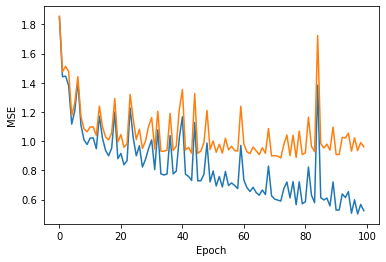

In [0]:
train_epoch_cost, valid_epoch_cost = train(fc, train_loader, valid_loader, 100)

plt.plot(range(len(train_epoch_cost)), train_epoch_cost)
plt.plot(range(len(valid_epoch_cost)), valid_epoch_cost)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.show()

In [0]:
print(compute_epoch_loss(fc, test_loader))

tensor(1.2286, device='cuda:0')


In [0]:
del fc

## CNN + FC

In [0]:
train_data = pd.read_csv('train1.csv')
valid_data = pd.read_csv('valid1.csv')
test_data = pd.read_csv('test1.csv')

In [0]:
NUM_FEATURES = train_data.shape[1] - 2 - len(overview_dictionary)
train_data.columns[(NUM_FEATURES+2):]

Index(['The', 'child', 'of', 'parents', 'living', 'on', 'a', ',', 'Victor',
       'is',
       ...
       'dysfunctional', 'Many', 'circus', 'deaf', 'identities', 'Pete', 'mute',
       '35', 'Devil', 'People'],
      dtype='object', length=3884)

In [0]:
train_data.drop(train_data.columns[(NUM_FEATURES+2):], axis = 1).to_csv('train2.csv', index = False)
valid_data.drop(valid_data.columns[(NUM_FEATURES+2):], axis = 1).to_csv('valid2.csv', index = False)
test_data.drop(test_data.columns[(NUM_FEATURES+2):], axis = 1).to_csv('test2.csv', index = False)

train_dataset = PosterDataset(csv_path='train2.csv',
                              text = train_text_indices,
                              transform=custom_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE, 
                          shuffle=True,
                          num_workers=0)

valid_dataset = PosterDataset(csv_path='valid2.csv',
                             text = valid_text_indices,
                             transform=custom_transform)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE, 
                          shuffle=True,
                          num_workers=0)

test_dataset = PosterDataset(csv_path='test2.csv',
                             text = test_text_indices,
                             transform=custom_transform)

test_loader = DataLoader(dataset=test_dataset,
                          batch_size=BATCH_SIZE, 
                          shuffle=True,
                          num_workers=0)

In [0]:
LEARNING_RATE = 0.0001
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [2,3,4]
OUTPUT_DIM = NUM_FEATURES

PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

NUM_FEATURES = train_data.shape[1] - 2 - len(overview_dictionary) + 300

class Ultimate(nn.Module):

    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, pad_idx):
        super(Ultimate, self).__init__()
        
        self.linear1 = nn.Linear((NUM_FEATURES), (NUM_FEATURES)*2)
        self.linear2 = nn.Linear((NUM_FEATURES)*2, (NUM_FEATURES)*2)
        self.linear3 = nn.Linear((NUM_FEATURES)*2, (NUM_FEATURES)*2)
        self.linear4 = nn.Linear((NUM_FEATURES)*2, (NUM_FEATURES)*2)
        self.linear5 = nn.Linear((NUM_FEATURES)*2, 1)

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
               
        self.dropout = nn.Dropout(0.5)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        self.dropout3 = nn.Dropout(0.5)
        self.dropout4 = nn.Dropout(0.5)

        self.bn = nn.BatchNorm1d(n_filters*len(filter_sizes))
        self.bn1 = nn.BatchNorm1d(NUM_FEATURES*2)
        self.bn2 = nn.BatchNorm1d(NUM_FEATURES*2)
        self.bn3 = nn.BatchNorm1d(NUM_FEATURES*2)
        self.bn4 = nn.BatchNorm1d(NUM_FEATURES*2)

    def forward(self, others, text):
        
        embedded = self.embedding(text)
        embedded = embedded.unsqueeze(1)
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]      
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim = 1))
        #cat = torch.cat(pooled, dim = 1)

        out = torch.cat((others.float(), cat), dim = 1)
        out = self.linear1(out)
        out = torch.tanh(out)
        out = self.dropout1(out)
        out = self.bn1(out)

        out = self.linear2(out)
        out = torch.tanh(out)
        out = self.dropout2(out)
        out = self.bn2(out)

        out = self.linear3(out)
        out = torch.tanh(out)
        out = self.dropout3(out)
        out = self.bn3(out)

        out = self.linear4(out)
        out = torch.tanh(out)
        out = self.dropout4(out)
        out = self.bn4(out)

        out = self.linear5(out)
        
        return out.view(-1)
      
torch.manual_seed(0)

ultimate = Ultimate(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, PAD_IDX)
ultimate.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
ultimate.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
ultimate.to(DEVICE)

optimizer = torch.optim.Adam(ultimate.parameters(), lr=LEARNING_RATE, weight_decay=0.05)

Epoch: 001/400 | Train: 36.112 | Valid: 36.070
Time elapsed: 0.08 min
Epoch: 002/400 | Train: 26.187 | Valid: 26.269
Time elapsed: 0.16 min
Epoch: 003/400 | Train: 10.852 | Valid: 10.785
Time elapsed: 0.24 min
Epoch: 004/400 | Train: 2.957 | Valid: 2.920
Time elapsed: 0.32 min
Epoch: 005/400 | Train: 1.847 | Valid: 1.835
Time elapsed: 0.40 min
Epoch: 006/400 | Train: 1.764 | Valid: 1.754
Time elapsed: 0.48 min
Epoch: 007/400 | Train: 1.714 | Valid: 1.690
Time elapsed: 0.56 min
Epoch: 008/400 | Train: 1.514 | Valid: 1.508
Time elapsed: 0.64 min
Epoch: 009/400 | Train: 1.596 | Valid: 1.604
Time elapsed: 0.72 min
Epoch: 010/400 | Train: 1.601 | Valid: 1.590
Time elapsed: 0.80 min
Epoch: 011/400 | Train: 1.760 | Valid: 1.743
Time elapsed: 0.88 min
Epoch: 012/400 | Train: 1.485 | Valid: 1.486
Time elapsed: 0.96 min
Epoch: 013/400 | Train: 1.547 | Valid: 1.550
Time elapsed: 1.04 min
Epoch: 014/400 | Train: 1.459 | Valid: 1.456
Time elapsed: 1.12 min
Epoch: 015/400 | Train: 1.679 | Valid: 1.6

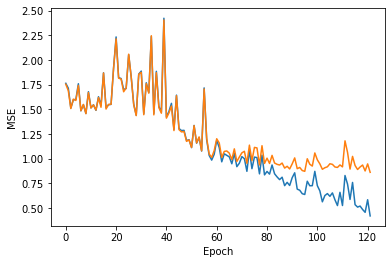

In [0]:
train_epoch_cost, valid_epoch_cost = train(ultimate, train_loader, valid_loader, 400)

plt.plot(range(len(train_epoch_cost)-5), train_epoch_cost[5:])
plt.plot(range(len(valid_epoch_cost)-5), valid_epoch_cost[5:])
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.show()

In [0]:
print(compute_epoch_loss(ultimate, test_loader))
print(1 - compute_epoch_loss(ultimate, test_loader).cpu().numpy()/np.cov(test_data['IMDBscore']))

tensor(0.8765, device='cuda:0')
0.4108517105389554


In [0]:
#del ultimate

# CNN only

In [0]:
LEARNING_RATE = 0.0001
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [2,3,4]
NUM_FEATURES = 300
OUTPUT_DIM = NUM_FEATURES

PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]



class CNNonly(nn.Module):

    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, pad_idx):
        super(CNNonly, self).__init__()
        
        self.linear1 = nn.Linear((NUM_FEATURES), (NUM_FEATURES)*2)
        self.linear2 = nn.Linear((NUM_FEATURES)*2, (NUM_FEATURES)*2)
        self.linear3 = nn.Linear((NUM_FEATURES)*2, (NUM_FEATURES)*2)
        self.linear4 = nn.Linear((NUM_FEATURES)*2, (NUM_FEATURES))
        self.linear5 = nn.Linear((NUM_FEATURES), 1)

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
               
        self.dropout = nn.Dropout(0.6)


    def forward(self, others, text):
        
        embedded = self.embedding(text)
        embedded = embedded.unsqueeze(1)
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]      
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim = 1))

        out = self.linear5(cat)
        
        return out.view(-1)
      
torch.manual_seed(0)

cnnonly = CNNonly(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, PAD_IDX)
cnnonly.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
cnnonly.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
cnnonly.to(DEVICE)

optimizer = torch.optim.Adam(cnnonly.parameters(), lr=LEARNING_RATE, weight_decay=0)

In [0]:
train_epoch_cost, valid_epoch_cost = train(cnnonly, train_loader, valid_loader, 100)

plt.plot(range(len(train_epoch_cost)), train_epoch_cost)
plt.plot(range(len(valid_epoch_cost)), valid_epoch_cost)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.show()

Epoch: 001/100 | Train: 2.319 | Valid: 2.295
Time elapsed: 0.11 min
Epoch: 002/100 | Train: 2.087 | Valid: 2.062
Time elapsed: 0.21 min
Epoch: 003/100 | Train: 1.939 | Valid: 1.923
Time elapsed: 0.31 min
Epoch: 004/100 | Train: 1.830 | Valid: 1.827
Time elapsed: 0.41 min
Epoch: 005/100 | Train: 1.747 | Valid: 1.756
Time elapsed: 0.51 min
Epoch: 006/100 | Train: 1.697 | Valid: 1.725
Time elapsed: 0.62 min
Epoch: 007/100 | Train: 1.644 | Valid: 1.686
Time elapsed: 0.72 min
Epoch: 008/100 | Train: 1.593 | Valid: 1.645
Time elapsed: 0.82 min
Epoch: 009/100 | Train: 1.553 | Valid: 1.618
Time elapsed: 0.92 min
Epoch: 010/100 | Train: 1.538 | Valid: 1.618
Time elapsed: 1.03 min
Epoch: 011/100 | Train: 1.490 | Valid: 1.575
Time elapsed: 1.13 min
Epoch: 012/100 | Train: 1.467 | Valid: 1.562
Time elapsed: 1.23 min
Epoch: 013/100 | Train: 1.446 | Valid: 1.552
Time elapsed: 1.33 min
Epoch: 014/100 | Train: 1.421 | Valid: 1.534
Time elapsed: 1.43 min
Epoch: 015/100 | Train: 1.401 | Valid: 1.523
Tim

KeyboardInterrupt: ignored

In [0]:
print(compute_epoch_loss(cnnonly, valid_loader))
print(1 - compute_epoch_loss(cnnonly, valid_loader).cpu().numpy()/np.cov(valid_data['IMDBscore']))

tensor(1.2892, device='cuda:0')
0.13643285395414684


In [0]:
#del cnnonly

In [0]:
def compute_epoch_loss1(model, data_loader):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for labels, others, text in data_loader:
            others = others.to(DEVICE)
            labels = labels.to(DEVICE)
            text = text.to(DEVICE)
            preds = model(others, text)[0]

            loss = torch.sum((preds - labels)**2)
            num_examples += labels.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss

def train1(model, train_loader, valid_loader, num_epochs):

    train_epoch_cost  = []
    valid_epoch_cost  = []
    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (labels, others, text) in enumerate(train_loader):

            others = others.to(DEVICE)
            labels = labels.to(DEVICE)
            text = text.to(DEVICE)
            preds = model(others, text)[0]

            cost = torch.mean((preds - labels)**2)
            optimizer.zero_grad()

            cost.backward()

            optimizer.step()
  
        with torch.set_grad_enabled(False): 
            
            train_cost = compute_epoch_loss1(model, train_loader)
            valid_cost = compute_epoch_loss1(model, valid_loader)
            print('Epoch: %03d/%03d | Train: %.3f | Valid: %.3f' % (
                  epoch+1, num_epochs, 
                  train_cost,
                  valid_cost))
            train_epoch_cost.append(train_cost)
            valid_epoch_cost.append(valid_cost)
            if valid_cost < 0.87:
              break

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    with torch.set_grad_enabled(False):
        print('Valid accuracy: %.2f%%' % (compute_epoch_loss1(model, valid_loader)))
        
    print('Total Time: %.2f min' % ((time.time() - start_time)/60))
    
    return train_epoch_cost, valid_epoch_cost

In [0]:
LEARNING_RATE = 0.0001
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [2,3,4]
OUTPUT_DIM = NUM_FEATURES

PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

NUM_FEATURES = 300

class CNNextract(nn.Module):

    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, pad_idx):
        super(CNNextract, self).__init__()
        
        self.linear1 = nn.Linear((NUM_FEATURES), (NUM_FEATURES)*2)
        self.linear2 = nn.Linear((NUM_FEATURES)*2, (NUM_FEATURES)*2)
        self.linear3 = nn.Linear((NUM_FEATURES)*2, (NUM_FEATURES)*2)
        self.linear4 = nn.Linear((NUM_FEATURES)*2, (NUM_FEATURES))
        self.linear5 = nn.Linear((NUM_FEATURES), 1)

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
               
        self.dropout = nn.Dropout(0.6)


    def forward(self, others, text):
        
        embedded = self.embedding(text)
        embedded = embedded.unsqueeze(1)
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]      
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        pooled = torch.cat(pooled, dim = 1)
        cat = self.dropout(pooled)
        out = self.linear5(cat)
        
        return out.view(-1), pooled
      
torch.manual_seed(0)

cnnextract = CNNextract(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, PAD_IDX)
cnnextract.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
cnnextract.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
cnnextract.to(DEVICE)

optimizer = torch.optim.Adam(cnnextract.parameters(), lr=LEARNING_RATE, weight_decay=0)

In [0]:
train_epoch_cost, valid_epoch_cost = train1(cnnextract, train_loader, valid_loader, 100)

plt.plot(range(len(train_epoch_cost)), train_epoch_cost)
plt.plot(range(len(valid_epoch_cost)), valid_epoch_cost)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.show()

Epoch: 001/100 | Train: 2.319 | Valid: 2.295
Time elapsed: 0.10 min
Epoch: 002/100 | Train: 2.087 | Valid: 2.062
Time elapsed: 0.20 min
Epoch: 003/100 | Train: 1.939 | Valid: 1.923
Time elapsed: 0.30 min
Epoch: 004/100 | Train: 1.830 | Valid: 1.827
Time elapsed: 0.40 min
Epoch: 005/100 | Train: 1.747 | Valid: 1.756
Time elapsed: 0.50 min
Epoch: 006/100 | Train: 1.697 | Valid: 1.725
Time elapsed: 0.60 min
Epoch: 007/100 | Train: 1.644 | Valid: 1.686
Time elapsed: 0.71 min
Epoch: 008/100 | Train: 1.593 | Valid: 1.645
Time elapsed: 0.81 min
Epoch: 009/100 | Train: 1.553 | Valid: 1.618
Time elapsed: 0.91 min
Epoch: 010/100 | Train: 1.538 | Valid: 1.618
Time elapsed: 1.01 min
Epoch: 011/100 | Train: 1.490 | Valid: 1.575
Time elapsed: 1.11 min
Epoch: 012/100 | Train: 1.467 | Valid: 1.562
Time elapsed: 1.21 min
Epoch: 013/100 | Train: 1.446 | Valid: 1.552
Time elapsed: 1.31 min
Epoch: 014/100 | Train: 1.421 | Valid: 1.534
Time elapsed: 1.41 min
Epoch: 015/100 | Train: 1.401 | Valid: 1.523
Tim

KeyboardInterrupt: ignored

In [0]:
train_dataset1 = PosterDataset(csv_path='train1.csv',
                              text = train_text_indices,
                              transform=custom_transform)

train_loader1 = DataLoader(dataset=train_dataset1,
                          batch_size=BATCH_SIZE, 
                          shuffle=False,
                          num_workers=0)

valid_dataset1 = PosterDataset(csv_path='valid1.csv',
                             text = valid_text_indices,
                             transform=custom_transform)

valid_loader1 = DataLoader(dataset=valid_dataset1,
                          batch_size=BATCH_SIZE, 
                          shuffle=False,
                          num_workers=0)

test_dataset1 = PosterDataset(csv_path='test1.csv',
                             text = test_text_indices,
                             transform=custom_transform)

test_loader1 = DataLoader(dataset=test_dataset1,
                          batch_size=BATCH_SIZE, 
                          shuffle=False,
                          num_workers=0)

In [0]:
train_extracted = np.zeros((train_X.shape[0],300))
index = 0
with torch.no_grad():
    for labels, others, text in train_loader:
        others = others.to(DEVICE)
        labels = labels.to(DEVICE)
        text = text.to(DEVICE)
        features = cnnextract(others, text)[1].cpu().numpy()
        l = features.shape[0]
        train_extracted[index:(index+l),:] = features
        index += l

valid_extracted = np.zeros((valid_X.shape[0],300))
index = 0
with torch.no_grad():
    for labels, others, text in valid_loader:
        others = others.to(DEVICE)
        labels = labels.to(DEVICE)
        text = text.to(DEVICE)
        features = cnnextract(others, text)[1].cpu().numpy()
        l = features.shape[0]
        valid_extracted[index:(index+l),:] = features
        index += l

test_extracted = np.zeros((test_X.shape[0],300))
index = 0
with torch.no_grad():
    for labels, others, text in test_loader:
        others = others.to(DEVICE)
        labels = labels.to(DEVICE)
        text = text.to(DEVICE)
        features = cnnextract(others, text)[1].cpu().numpy()
        l = features.shape[0]
        test_extracted[index:(index+l),:] = features
        index += l

In [0]:
for col in range(300):
  mean_feature = np.mean(train_extracted[:,col])
  sd_feature = np.std(train_extracted[:,col])
  if sd_feature != 0:
    train_extracted[:,col] = (train_extracted[:,col] - mean_feature) / sd_feature
    valid_extracted[:,col] = (valid_extracted[:,col] - mean_feature) / sd_feature
    test_extracted[:,col] = (test_extracted[:,col] - mean_feature) / sd_feature
  else:
    train_extracted[:,col] = (train_extracted[:,col] - mean_feature) 
    valid_extracted[:,col] = (valid_extracted[:,col] - mean_feature) 
    test_extracted[:,col] = (test_extracted[:,col] - mean_feature)

In [0]:
train_X_ult = pd.concat([train_X.iloc[:,:2132], pd.DataFrame(train_extracted)], axis=1)
valid_X_ult = pd.concat([valid_X.iloc[:,:2132], pd.DataFrame(valid_extracted)], axis=1)
test_X_ult = pd.concat([test_X.iloc[:,:2132], pd.DataFrame(test_extracted)], axis=1)
print(train_X_ult.shape)
print(valid_X_ult.shape)
print(test_X_ult.shape)
train_X_ult

(13600, 2432)
(2914, 2432)
(2915, 2432)


,runtime,num_faces,hue,hue_sd,saturation,saturation_sd,brightness,brightness_sd,blue,blue_sd,green,green_sd,red,red_sd,drama,comedy,romance,biography,action,thriller,fantasy,documentary,horror,crime,history,family,short,music,sport,animation,sci-fi,adventure,mystery,musical,war,western,news,ken loach,sally potter,bernard rose,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,-0.214485,-0.628921,1.154814,0.464228,0.604670,1.092677,-0.601549,0.645886,-0.241329,0.261589,-0.499044,0.827856,-0.579642,0.949121,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.625223,1.086734,1.086350,0.287679,-0.595777,0.804143,3.242527,0.802036,2.387045,-0.880988,-0.207614,0.336268,0.031905,-0.068882,-1.390409,-0.981077,-0.409407,0.420615,0.953494,0.966000,0.382165,-0.732373,1.918205,-0.374822,0.352351,-0.304119,-0.023968,2.163330,0.338635,0.049128,1.136356,0.033316,0.364449,0.538035,0.603681,0.250775,0.126850,-0.458827,-0.975896,0.506047
1,-0.052971,0.408349,0.538177,1.880028,-0.193467,-1.276406,1.293056,-0.775433,0.901365,-0.593084,0.811212,-0.722713,1.462050,-0.604356,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.539496,0.486813,0.207234,0.968783,0.389179,1.653607,-0.468241,1.805220,0.835107,0.253748,-0.037003,1.586918,0.838233,1.958849,0.948491,-0.177280,0.978269,0.292948,0.918663,-0.076366,-0.054703,0.106296,0.108115,0.307157,0.271222,2.286471,0.873148,-0.388109,-0.130256,0.455939,0.274432,0.424481,0.563721,0.271158,1.531160,0.111676,-0.122038,0.073754,0.670234,-0.377827
2,0.054705,-0.628921,-0.283015,0.304720,-0.266142,0.062245,-0.936989,-0.492394,-0.712967,-0.479449,-0.681052,-0.444899,-0.784298,-0.614756,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.516006,-1.207765,-0.541765,-2.017924,-0.149730,0.196069,-0.829674,-0.896972,-0.272755,-1.189346,-1.107041,-1.566443,-1.541402,-0.881337,-2.355924,-0.939564,-1.501965,-0.121736,-1.086875,-1.615179,-0.605254,-1.146506,-0.646849,-0.203030,-0.939417,-1.108992,-0.847758,-0.926692,-1.674005,-1.946486,-1.377929,0.811937,-1.133854,-2.199346,-1.005478,-0.394820,0.192542,-0.960315,-0.458293,-2.678129
3,0.350815,0.408349,0.341538,2.222262,0.342071,1.947585,1.340273,-0.354779,0.577779,1.925322,0.448468,2.316132,1.569266,-0.448050,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.857541,-1.298051,-2.186424,-0.179232,-0.457254,-1.847401,-1.262881,-0.071202,-1.308897,-1.208040,0.079026,-0.019072,-1.334386,0.641912,0.365676,-0.610637,1.877900,0.160183,-1.490242,1.053740,-0.524262,-0.538174,0.303422,-1.135174,-0.848750,-1.450568,-0.426233,-0.609896,-1.420703,0.156580,-0.118254,-1.824009,-0.305540,-0.398202,-0.725666,0.630703,-1.087377,-0.884443,-0.698845,-0.207588
4,-0.079890,0.408349,0.107022,0.753671,0.621321,0.029833,0.785184,0.009698,0.636177,-0.377338,0.207612,0.440401,0.410982,1.489210,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.826422,1.240374,-1.452656,-0.008476,-0.186348,-1.652711,-0.457871,1.659404,-1.372540,-0.055675,-0.218764,0.452682,0.010722,-1.145803,0.850951,-0.328842,0.622123,-0.360639,-0.205025,-0.300662,-1.248440,0.216678,-1.462947,-1.297063,0.592365,-1.600084,-2.097734,-0.926692,-1.861821,-1.500516,-1.868916,-0.206944,0.640194,-0.244921,-1.233447,1.918336,0.162501,-0.656333,-0.458293,-0.264473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13595,0.189300,-0.628921,-0.614651,0.802864,-1.0048

In [0]:
rfreg_ult = RandomForestRegressor(max_depth=32, random_state=0,
                            n_estimators=100)

rfreg_ult.fit(train_X_ult, train_data['IMDBscore'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=32,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [0]:
print('Train R^2: ', rfreg_ult.score(train_X_ult, train_data['IMDBscore']))
print('Train MSE: ', mean_squared_error(rfreg_ult.predict(train_X_ult), train_data['IMDBscore']))

print('Valid R^2: ', rfreg_ult.score(valid_X_ult, valid_data['IMDBscore']))
print('Valid MSE: ', mean_squared_error(rfreg_ult.predict(valid_X_ult), valid_data['IMDBscore']))

print('Test R^2: ', rfreg_ult.score(test_X_ult, test_data['IMDBscore']))
print('Test MSE: ', mean_squared_error(rfreg_ult.predict(test_X_ult), test_data['IMDBscore']))

Train R^2:  0.9144363555755041
Train MSE:  0.12789894205823304
Valid R^2:  0.3998152644667904
Valid MSE:  0.8957203882932084
Test R^2:  0.4052954349261666
Test MSE:  0.8844129259718893


Index([  'documentary',       'runtime',        'horror',         'drama',
           'animation',        'action',         'short',      'thriller',
              'sci-fi',             127, 'saturation_sd',        'hue_sd',
                   241,           'red',           'hue',             260,
               'green',       'blue_sd',             159,             116],
      dtype='object')
[0.13500417 0.09856198 0.07889796 0.04690929 0.01933112 0.01723976
 0.00913587 0.00519886 0.00468423 0.00346901 0.00300907 0.00268867
 0.00255265 0.0025324  0.00247068 0.00242599 0.00242169 0.00241571
 0.00241162 0.00235437]


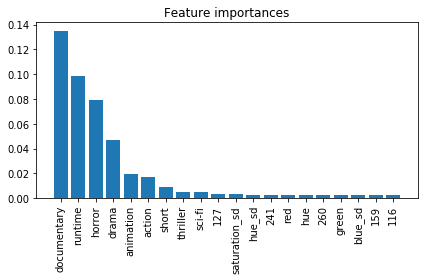

In [0]:
importances_order = np.argsort(rfreg_ult.feature_importances_)[::-1]
print(train_X_ult.columns[importances_order[:20]])
print(rfreg_ult.feature_importances_[importances_order[:20]])
plt.figure()
plt.title("Feature importances")
plt.bar(range(20),rfreg_ult.feature_importances_[importances_order[:20]])
plt.xticks(range(20), train_X_ult.columns[importances_order[:20]], rotation='vertical')
plt.tight_layout()
plt.savefig('drive/My Drive/randomforest_ult.png')
plt.show()

In [0]:
np.random.seed(0)
breaks = [0, 1, 14, 37, 529, 2132, 6016]
mse_permute = []
for i in range(len(breaks)-1):
  iters = np.zeros(10)
  for j in range(10):
    train_X_ult_copy = train_X_ult.copy()
    train_X_ult_copy.iloc[:,breaks[i]:breaks[i+1]] = np.random.permutation(train_X_ult_copy.iloc[:,breaks[i]:breaks[i+1]])
    #rfreg_permute = RandomForestRegressor(max_depth=32, random_state=0,
    #                        n_estimators=100)
    #rfreg_permute.fit(train_X_copy, train_data['IMDBscore'])
    iters[j] = mean_squared_error(rfreg_ult.predict(train_X_ult_copy), train_data['IMDBscore'])
  mse_permute.append(np.mean(iters))
  print(i)

print(mse_permute)

0
1
2
3
4
5
[0.8032500068501189, 0.2041100411328026, 1.6313018027436832, 0.13197249914812542, 0.13593378808089768, 0.8585381666745109]


In [0]:
print(mse_permute)
print(mean_squared_error(rfreg_ult.predict(train_X_ult), train_data['IMDBscore']))

[0.8032500068501189, 0.2041100411328026, 1.6313018027436832, 0.13197249914812542, 0.13593378808089768, 0.8585381666745109]
0.12789894205823304


['genre' 'synopses' 'runtime' 'poster' 'actor' 'director']
[1.50340286 0.73063922 0.67535106 0.0762111  0.00803485 0.00407356]


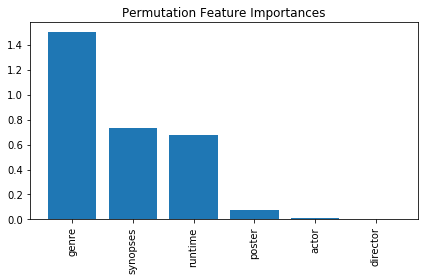

In [0]:
importances_permute = np.array(mse_permute) - mean_squared_error(rfreg_ult.predict(train_X_ult), train_data['IMDBscore'])
importances_order = np.argsort(importances_permute)[::-1]

groups = np.array(['runtime','poster','genre','director','actor','synopses'])
print(groups[importances_order])
print(importances_permute[importances_order])
plt.figure()
plt.title("Permutation Feature Importances")
plt.bar(range(len(groups)), importances_permute[importances_order])
plt.xticks(range(len(groups)), groups[importances_order], rotation='vertical')
plt.tight_layout()
plt.savefig('drive/My Drive/permutation_ult.png')
plt.show()


In [0]:
train_X_ult1 = pd.concat([train_X, pd.DataFrame(train_extracted)], axis=1)
valid_X_ult1 = pd.concat([valid_X, pd.DataFrame(valid_extracted)], axis=1)
test_X_ult1 = pd.concat([test_X, pd.DataFrame(test_extracted)], axis=1)
print(train_X_ult1.shape)
print(valid_X_ult1.shape)
print(test_X_ult1.shape)

rfreg_ult1 = RandomForestRegressor(max_depth=16, random_state=0,
                            n_estimators=100)

rfreg_ult1.fit(train_X_ult1, train_data['IMDBscore'])

(13600, 6316)
(2914, 6316)
(2915, 6316)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=16,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [0]:
print('Train R^2: ', rfreg_ult1.score(train_X_ult1, train_data['IMDBscore']))
print('Train MSE: ', mean_squared_error(rfreg_ult1.predict(train_X_ult1), train_data['IMDBscore']))

print('Valid R^2: ', rfreg_ult1.score(valid_X_ult1, valid_data['IMDBscore']))
print('Valid MSE: ', mean_squared_error(rfreg_ult1.predict(valid_X_ult1), valid_data['IMDBscore']))

print('Test R^2: ', rfreg_ult1.score(test_X_ult1, test_data['IMDBscore']))
print('Test MSE: ', mean_squared_error(rfreg_ult1.predict(test_X_ult1), test_data['IMDBscore']))

Train R^2:  0.7682352750291483
Train MSE:  0.34643759425589593
Valid R^2:  0.3960772520764376
Valid MSE:  0.9012990271880431
Test R^2:  0.4147164651787304
Test MSE:  0.8704024720075665


## Res34


In [0]:
class PosterDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.img_names = df['posterID'].values
        self.y = df['IMDBscore'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir, self.img_names[index]))
        
        if img.getbands()[0] == 'L':
            img = img.convert('RGB')
            
        if len(img.getbands()) == 4:
            img = img.convert('RGB')
        
        if self.transform:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [0]:
custom_transform = transforms.Compose([transforms.Resize([224, 224]),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = PosterDataset(csv_path='train1.csv',
                                 img_dir='poster/',
                                 transform=custom_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE, 
                          shuffle=True,
                          num_workers=0)


valid_dataset = PosterDataset(csv_path='valid1.csv',
                                 img_dir='poster/',
                                 transform=custom_transform)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE, 
                          shuffle=True,
                          num_workers=0)



# Checking the dataset
for images, labels in train_loader:  
    print('Image dimensions:', images.shape)
    print('Label dimensions:', labels.shape)
    break

for images, labels in valid_loader:  
    print('Image dimensions:', images.shape)
    print('Label dimensions:', labels.shape)
    break

In [0]:
toPIL = transforms.Compose([transforms.Normalize((-1, -1, -1), (2, 2, 2)),
                            transforms.ToPILImage()])

for images, labels in train_loader:  
    plt.imshow(toPIL(images[0]))
    plt.show()
    
    print("label: " + str(labels[0]))
    break

In [0]:
def compute_epoch_loss(model, data_loader):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
          
            preds = model(features)
            loss = torch.sum((preds - targets)**2)
            
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss

In [0]:
def train(model, train_loader, test_loader):

    minibatch_cost, epoch_cost = [], []
    start_time = time.time()
    for epoch in range(NUM_EPOCHS):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(DEVICE)
            targets = targets.to(DEVICE)

            ### FORWARD AND BACK PROP
            preds = model(features)
            cost = torch.mean((preds - targets)**2)

            optimizer.zero_grad()

            cost.backward()
            minibatch_cost.append(cost)

            ### UPDATE MODEL PARAMETERS
            optimizer.step()

            ### LOGGING
            if not batch_idx % 100:
                print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                       %(epoch+1, NUM_EPOCHS, batch_idx, 
                         len(train_loader), cost))

    
        with torch.set_grad_enabled(False): # save memory during inference
            
            cost = compute_epoch_loss(model, train_loader)
            print('Epoch: %03d/%03d | Train: %.3f | Test: %.3f' % (
                  epoch+1, NUM_EPOCHS, 
                  cost,
                  compute_epoch_loss(model, test_loader)))
            epoch_cost.append(cost)

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    with torch.set_grad_enabled(False): # save memory during inference
        print('Test accuracy: %.2f%%' % (compute_epoch_loss(model, test_loader)))
        
    print('Total Time: %.2f min' % ((time.time() - start_time)/60))
    
    return minibatch_cost, epoch_cost

In [0]:
from torchvision import models


class Res34(nn.Module):

    def __init__(self, num_classes):
        super(Res34, self).__init__()
        
        self.res34 = models.resnet34(pretrained=False)
        #self.incept3 = models.inception_v3(pretrained=False, aux_logits = False)
        
        self.linear1 = nn.Linear(1000, 2000)
        self.linear2 = nn.Linear(2000, 2000)
        self.linear3 = nn.Linear(2000, 2000)
        self.linear4 = nn.Linear(2000, 1000)
        self.linear5 = nn.Linear(1000, num_classes)
        
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        self.dropout3 = nn.Dropout(0.5)
        self.dropout4 = nn.Dropout(0.5)

    def forward(self, x):
        
        out = self.res34(x)
        
        out = self.linear1(out)
        out = F.relu(out)
        #out = self.dropout1(out)

        out = self.linear2(out)
        out = F.relu(out)
        #out = self.dropout2(out)

        out = self.linear3(out)
        out = F.relu(out)
        #out = self.dropout3(out)

        out = self.linear4(out)
        out = F.relu(out)
        #out = self.dropout4(out)

        out = self.linear5(out)
        
        return out.view(-1)
      
#torch.manual_seed(RANDOM_SEED)

res34 = Res34(1)
res34.to(DEVICE)

optimizer = torch.optim.Adam(res34.parameters(), lr=LEARNING_RATE, weight_decay = 0)

In [0]:
minibatch_cost, epoch_cost = train(res34, train_loader, test_loader)


plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()